<h1><center><b>AutoEncoder Pretrained NN Model</b></center></h1>

## Import and Load Dataset

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [2]:
# Load the preprocessed training and test datasets
train_data = pd.read_csv('dataset_preprocessed/LinearImput_Feature_Scale_Cap_Clean_Train.csv')
test_data = pd.read_csv('dataset_preprocessed/LinearImput_Feature_Scale_Cap_Clean_Test.csv')

In [3]:
# Separate features and target from the training dataset
X_train = train_data.drop(columns=['target'])
Y_train = train_data['target']
X_test = test_data.drop(columns=['target'])
Y_test = test_data['target']

## Build and train the Encoder

In [6]:
# Define the autoencoder architecture
encoding_dim = 10  # Dimensionality of the encoded space

autoencoder = Sequential()

# Encoder
autoencoder.add(Input(shape=(X_train.shape[1],)))

autoencoder.add(Dense(32))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(16))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(encoding_dim))
autoencoder.add(LeakyReLU(alpha=0.1))

# Decoder
autoencoder.add(Dense(16))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(32))
autoencoder.add(LeakyReLU(alpha=0.1))

autoencoder.add(Dense(X_train.shape[1]))

autoencoder.add(LeakyReLU(alpha=0.1))

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

/home/siddhesh/miniconda3/envs/env1/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
# Train the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_train, X_train, 
                epochs=50, 
                batch_size=256, 
                shuffle=True, 
                validation_data=(X_test, X_test),
                callbacks=[early_stopping])

Epoch 1/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1700 - val_loss: 0.0466
Epoch 2/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0351 - val_loss: 0.0205
Epoch 3/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 4/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 5/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0156 - val_loss: 0.0145
Epoch 6/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 7/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 8/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 9/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 10/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 11/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0108 - val_loss: 0.0097
Epoch 12/50
3067/3067 ━━━━━━━━

In [13]:
# The input to the autoencoder
encoder_input = Input(shape=(X_train.shape[1],))

# Build the encoder using the layers from the autoencoder
x = autoencoder.layers[0](encoder_input)  # Dense(32)
x = autoencoder.layers[1](x)  # LeakyReLU
x = autoencoder.layers[2](x)  # Dense(16)
x = autoencoder.layers[3](x)  # LeakyReLU
x = autoencoder.layers[4](x)  # Dense(encoding_dim)
encoder_output = autoencoder.layers[5](x)  # LeakyReLU (encoded output)

# Create the encoder model
encoder = Model(inputs=encoder_input, outputs=encoder_output)

In [14]:
# Extract the encoded representations for the training and testing data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

24536/24536 ━━━━━━━━━━━━━━━━━━━━ 20s 801us/step
8179/8179 ━━━━━━━━━━━━━━━━━━━━ 7s 806us/step


In [16]:
print(X_train_encoded.shape)

(785133, 10)


In [18]:
# Save the encoder model
encoder.save('tf_models/encoder_model.keras')

## Build and train the classifier on top of encoder

In [35]:
model = Sequential()

# Input layer
model.add(Input(shape=(encoding_dim,)))

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))  # Regularization

# Hidden layers
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.3))

model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(8))
model.add(LeakyReLU(alpha=0.1))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

/home/siddhesh/miniconda3/envs/env1/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [36]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping_classifier = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train_encoded, Y_train,
          epochs=50, 
          batch_size=256, 
          validation_data=(X_test_encoded, Y_test), 
          callbacks=[lr_scheduler, early_stopping_classifier]
         )

Epoch 1/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - AUC: 0.9692 - Precision: 0.7684 - Recall: 0.7434 - accuracy: 0.9561 - loss: 0.1093 - val_AUC: 0.9920 - val_Precision: 0.7969 - val_Recall: 0.9457 - val_accuracy: 0.9722 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 2/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - AUC: 0.9882 - Precision: 0.8077 - Recall: 0.8677 - accuracy: 0.9681 - loss: 0.0748 - val_AUC: 0.9920 - val_Precision: 0.8444 - val_Recall: 0.8799 - val_accuracy: 0.9734 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 3/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.9912 - Precision: 0.8222 - Recall: 0.8986 - accuracy: 0.9720 - loss: 0.0636 - val_AUC: 0.9922 - val_Precision: 0.8427 - val_Recall: 0.8852 - val_accuracy: 0.9736 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 4/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.9901 - Precision: 0.8165 - Recall: 0.8769 - accuracy: 0.9699 - loss: 0.0682 - val_AUC: 0.9911 - val_Precision: 0.8305 - val_Recall: 

## Test the model

In [37]:
# Make predictions on the test set
Y_pred_prob = model.predict(X_test_encoded)

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 8s 937us/step


In [38]:
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

Accuracy: 97.56%

Confusion Matrix:
[[232694   4340]
 [  2040  22638]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.84      0.92      0.88     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.95      0.93    261712
weighted avg       0.98      0.98      0.98    261712



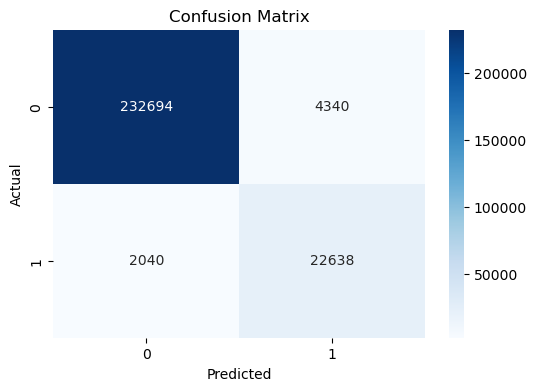

Precision: 0.84
Recall: 0.92
F1-Score: 0.88
ROC-AUC: 0.95


In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Visualizing the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Precision, Recall, F1-Score
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")